In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

/Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/utils.py:713: SyntaxWarning: invalid escape sequence '\{'
  path_main_file = os.path.join(os.getcwd(), f'gams\{gams_model}.gms')
/Users/celia/Documents/WorldBank/Energy_planning/SAPP_2025/Data/Planning-tools/utils.py:714: SyntaxWarning: invalid escape sequence '\{'
  path_setting_file = os.path.join(os.getcwd(), f'gams\{bins_settings}.csv')


In [2]:
# Load test data
inflows = pd.read_csv('data_test/hydro/inflow_baynes.csv')
hydro_namibia = pd.read_csv('data_test/hydro/hydro_namibia.csv')

In [3]:
# Process data in right format
inflows = inflows.set_index(['year', 'month', 'day']).stack()
inflows.index.names = ['year', 'month', 'day', 'hour']
inflows = inflows.to_frame().reset_index() 
inflows = inflows.loc[~((inflows.month == 2) & (inflows.day == 29))]  # ensuring we get 8760 hours
inflows = inflows.drop(columns=['year', 'month', 'day', 'hour']).squeeze().values
inflows 

array([ 97.4,  97.4,  97.4, ..., 108.2, 108.2, 108.2], shape=(8760,))

In [4]:
# Solving the model
# Options must be specified by the user.
# To deactivate the minimum reservoir level constraint (if not relevant), you should use reservoir_min = 0.
# This cell may take a few minutes (> 10min) to run

config = {
    'hours': 8760,
    'reservoir_size': 205000,  # in GWh
    'reservoir_min': 0.6,  # constraint that 60% of reservoir be filled during specified hours
    'hours_reservoir_min_constraints': np.arange(3 * 30 * 24, 6 * 30 * 24),  # specifying the hours when the minimum reservoir level constraints apply 
    'inflow': inflows
}


res, A_eq, b_eq = run_smoothing_reservoir(config)

True 219273.7097696563


In [5]:
# Checks
n = config['hours']
residual_eq = A_eq.dot(res.x) - b_eq
print("Max absolute residual in A_eq:", np.max(np.abs(residual_eq)))
print("Storage start vs end:", res.x[2], res.x[5*(n-1) + 2])
print("Difference (should be ≈ 0):", res.x[2] - res.x[5*(n-1) + 2])

Max absolute residual in A_eq: 3.207242116332054e-08
Storage start vs end: 5184.5173708748425 5184.5173708748425
Difference (should be ≈ 0): 0.0


In [7]:
new_inflow = res.x[3 : 5*n : 5]
stored = res.x[0 : 5*n : 5]  # what's getting in
out = res.x[1 : 5*n : 5]  # what's getting out
storage = res.x[2 : 5*n : 5] # storage level
hydro_namibia['baynes_smoothed_v2'] = new_inflow
hydro_namibia['baynes_storage'] = storage
hydro_namibia['baynes_stored'] = stored
hydro_namibia['baynes_out_of_storage'] = out

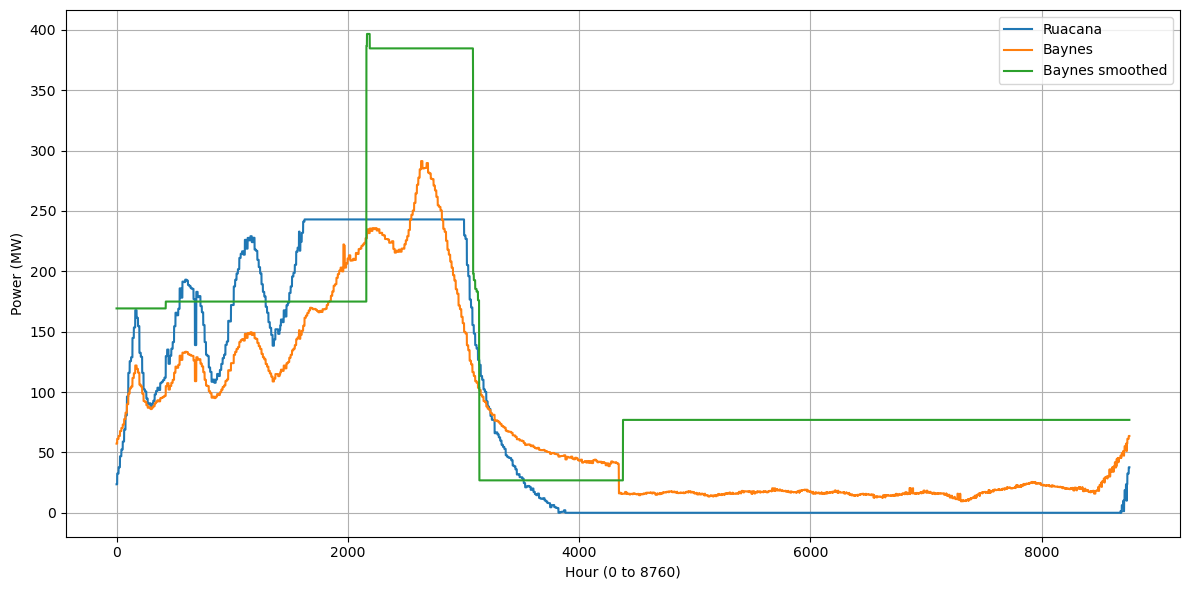

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(hydro_namibia.reset_index(drop=True).index, hydro_namibia['ruacana'], label='Ruacana')
plt.plot(hydro_namibia.reset_index(drop=True).index, hydro_namibia['baynes'], label='Baynes')
plt.plot(hydro_namibia.reset_index(drop=True).index, hydro_namibia['baynes_smoothed_v2'], label='Baynes smoothed')
# plt.plot(hydro_namibia.reset_index(drop=True).index, hydro_namibia['baynes_storage'], label='Baynes storage')

plt.xlabel('Hour (0 to 8760)')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Obtaining seasonal capacity factor
# Hourly values are not trustworthy, since hydro power plant is assumed to operate as a reservoir, and reservoir rules will be termined through dispatch decisions. Goal of the algorithm is to obtain a simple proxy for reservoir behavior, with the only objective to smooth reservoir production across seasons and inside a season

seasons_dict = {
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 2,
    6: 2,
    7: 3,
    8: 3,
    9: 3,
    10: 4,
    11: 4,
    12: 4
}  # grouping months into 4 seasons, to define according to user
hydro_namibia.reset_index(inplace=True)
hydro_namibia['season'] = hydro_namibia.apply(lambda row: seasons_dict[row['month']], axis=1)
hydro_namibia.groupby(['season'])[['baynes', 'baynes_smoothed_v2']].sum().reset_index()  # getting average capacity factor across seasons

,season,baynes,baynes_smoothed_v2
0,1,289904.2272,375502.635620
1,2,282230.4744,397793.000744
2,3,36365.1540,168086.534474
3,4,44885.7444,169889.711791
